# Investigation of the Equilibrium Paths of the Box Beam Reinforced with Ribs

In our [previous notebook](14_Investigation_of_the_Equilibrium_Paths_of_the_Unreinforced_Box_Beam.ipynb) we ascertained the existence of at least one complementary path in the equilibrium manifold of the unreinforced box beam. In this notebook we are going to perform an analogous investigation for the box beam reinforced with ribs.

* [Setup of the numerical model](#numerical-model)
* [Verification of the existence of other equilibrium paths](#verification)
* [Visualization of 3D equilibrium diagram and of deformation shapes](#visualization)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # import matplotlib
import tol_colors as tc  # import package for colorblind-friendly colors
from matplotlib.lines import (
    Line2D,
)  # class defining the characters for the marker styles
import os

# Set default plot settings
plt.rc(
    "axes", prop_cycle=plt.cycler("color", list(tc.tol_cset("bright")))
)
plt.rcParams["figure.dpi"] = 120  # set default dpi of figures
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams["axes.prop_cycle"].by_key()[
    "color"
]  # retrieve list with succession of standard matplotlib colors

# Enable interactive plots
%matplotlib widget

# Constants - Nastran subcase IDs
FIRST_SUBCASE_ID = 1
SECOND_SUBCASE_ID = 2

# Constants - Nastran card IDs
FORCE_SET_ID = 11
LOAD_SET_ID = 12

# Constants - displacement and load component indices
Z_INDEX = 2  # translation along z-axis

# Define path to analysis directory
analysis_directory_name = "15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

## Setup of the numerical model <a name="numerical-model"></a>

***

We consider the same box beam reinforced with ribs analyzed in our [eighth notebook](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb).

![Box beam subject to concentrated tip load.](resources/08_BoxBeamConcentratedLoad.svg "Box beam subject to concentrated tip load.")

In [2]:
import numpy as np

# Define geometry
AR = 9.0  # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3  # width [mm]
l = AR * w / 2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w * non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1 / 50  # t/h
t = h * non_dimensional_thickness  # shell thickness [mm]
print(
    f"""
Box beam dimensions:
- width: {w/1e3:.1f} m
- length: {l/1e3:.1f} m
- height: {h/1e3:.1f} m
- wall thickness: {t:.1f} mm\n"""
)

# Define ribs location
ribs_spacing = w / 2  # half of box beam's width
no_ribs = int(np.ceil(l / ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs
np.set_printoptions(precision=0)
print(f"Number of ribs: {no_ribs:.0f}")
print(f"Ribs' y-coordinate [mm]:")
print(ribs_y_locations)

# Define material
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio


Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm

Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


Let's define the mesh using a shell element of 59.9 mm, as found in a previous [mesh convergence study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#mesh-convergence). We use the function `mesh_box_beam_with_pyvista` from the `box_beam_utils` module and then we call the function `create_base_bdf_input` from the same module, which generates a `BDF` object of our box beam with material properties, nodes, elements, boundary conditions and output files defaults. Finally, we print the cards of the `BDF` object.

In [3]:
from resources import box_beam_utils

shell_element_length = 59.9  # [mm]
box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs(
    height=h,
    width=w,
    ribs_y_coordinates=ribs_y_locations,
    element_length=shell_element_length,
)
nodes_coordinates_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(
    young_modulus=E,
    poisson_ratio=nu,
    density=rho,
    shell_thickness=t,
    nodes_xyz_array=nodes_coordinates_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix,
)
print(box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 4514

bdf.elements: 0
  CQUAD4   : 4680

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we add a concentrated force in the positive $z$-direction at the center of the tip section, connecting with a RBE3 element the nodes on the edge of the section to a new node in the center.

In [4]:
# Add master node of tip section
tip_master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf.add_grid(tip_master_node_id, [w / 2, l, 0.0])

# Find id of the nodes on the edge of the tip rib
tolerance = (
    shell_element_length / 100
)  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1/100 of elements' length
tip_edge_nodes_ids = [
    nid
    for nid in box_beam_bdf.nodes
    if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - l) < tolerance)  # y = b
    & (
        np.abs((box_beam_bdf.nodes[nid].xyz[0]) < tolerance)  # x = 0
        | (np.abs(box_beam_bdf.nodes[nid].xyz[0] - w) < tolerance)  # x = w
        | (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h / 2) < tolerance)  # z = -h/2
        | (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h / 2) < tolerance)
    )
]  # z = h/2

# Add RBE3 to connect master node with edge nodes of tip rib
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(
    eid=rbe3_eid,
    refgrid=tip_master_node_id,
    refc="123456",
    weights=[1.0] * len(tip_edge_nodes_ids),
    comps=["123456"] * len(tip_edge_nodes_ids),
    Gijs=tip_edge_nodes_ids,
)

# Add concentrated force
concentrated_force_magnitude = 1.0
concentrated_force_direction = [0.0, 0.0, 1.0]
box_beam_bdf.add_force(
    sid=FORCE_SET_ID,
    node=tip_master_node_id,
    mag=concentrated_force_magnitude,
    xyz=concentrated_force_direction,
)

FORCE         11    4515              1.      0.      0.      1.

Finally we set up the arc-length method with default parameters calling the function `set_up_arc_length_method` from the `pynastran_utils` module.

In [5]:
from resources import (
    pynastran_utils,
)  # module with useful functions to work with pyNastran objects

pynastran_utils.set_up_arc_length_method(
    box_beam_bdf
)  # set up SOL 106 with arc-length method using default parameters

## Verification of the existence of other equilibrium paths <a name="verification"></a>

***

In a [previous sensitivity study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-analysis-parameters) of the nonlinear analysis parameters we obtained different load-displacement curves for different combination of error functions. While we previously attributed this discrepancy to the accuracy of the nonlinear solution, now we are going to investigate whether the equilibrium points actually belong to different equilibrium paths.

We are going to start with a first analysis using the load and energy error functions. We define two subcases with the following nonlinear analysis parameters:

1. concentrated tip load, load and energy error functions, default remaining parameters;
2. no load, load and displacement error functions with vector component method, fine nonlinear analysis parameters:
    - $\Delta\mu^1=0.01$,
    - $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$,
    - $\mathrm{MAXBIS}=10$,
    - $\mathrm{MINALR}=0.01$,
    - $\mathrm{MAXALR}=1.0001$,
    - $\mathrm{DESITER}=5$.
    - $\mathrm{MXINC}=100$.

Analogously to our last notebook, the idea is to use small arc-length increments in the second subcase while unloading the structure to accurately follow the equilibrium path and see what we find.

Let's recall the buckling load predicted by SOL 105 and create the two subcases.

In [6]:
# Create first subcase
SOL_105_BUCKLING_LOAD = 3101.0  # [N]
box_beam_bdf.add_load(
    sid=LOAD_SET_ID,
    scale=1.0,
    scale_factors=[2 * SOL_105_BUCKLING_LOAD],
    load_ids=[FORCE_SET_ID],
)  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(
    bdf=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID
)  # create subcase with defined load set

# Create second subcase
zero_load_set_id = LOAD_SET_ID + 1  # id of LOAD card
box_beam_bdf.add_load(
    zero_load_set_id, scale=1.0, scale_factors=[0.0], load_ids=[FORCE_SET_ID]
)  # add LOAD card with zero applied load
pynastran_utils.create_static_load_subcase(
    bdf=box_beam_bdf, subcase_id=SECOND_SUBCASE_ID, load_set_id=zero_load_set_id
)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(
    bdf=box_beam_bdf,
    subcase_id=SECOND_SUBCASE_ID,
    nlparm_id=SECOND_SUBCASE_ID,
    ninc=100,
    conv="PUV",
    eps_p=1e-3,
    eps_u=1e-3,
    max_bisect=10,
    minalr=0.01,
    maxalr=1.0001,
    desiter=5,
    maxinc=100,
)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis by calling the function `run_sol_106_with_kllrh_eigenvalues` from the `pynatran_utils` module, using `no_eigenvalues=10` to calculate the 10 smallest magnitude eigenvalues of the tangent stiffness matrix at each converged increment.

In [7]:
from resources import pynastran_utils

# Run analysis
no_eigenvalues = 10
input_name = "equilibrium_path_verification_pw"
sol_106_pw_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=box_beam_bdf.__deepcopy__({}),
    method_set_id=zero_load_set_id + 1,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    no_eigenvalues=no_eigenvalues,
    run_flag=False,
)

Nastran job equilibrium_path_verification_pw.bdf completed
Wall time: 1235.0 s


Similarly to our last notebook, now we want to plot the load-displacement diagram and the eigenvalues of the tangent stiffness matrix. For this reason, we define the two functions `plot_load_displacement_diagram` and `plot_tangent_stiffness_matrix_eigenvalues`. We use the first to plot the applied load against the tip displacement nondimensionalized with the length of the box beam, $u_{z,\,tip}/l$, and the second to plot the eigenvalues $\lambda$ of the tangent stiffness matrix against the increment number and the applied load.

In [8]:
def plot_load_displacement_diagram(disp, loads):
    _, load_displacement_ax = plt.subplots()  # create figure with one subplot
    for subcase in loads:  # iterate through the subcases
        load_displacement_ax.plot(
            disp[subcase][:, Z_INDEX] / l,
            loads[subcase][:, Z_INDEX] / SOL_105_BUCKLING_LOAD,
            marker=MARKERS[subcase - 1],
            label=f"Subcase {subcase:d}",
        )  # plot applied loads against displacement for each converged iteration
    load_displacement_ax.legend()  # set up legend
    plt.xlabel("$u_{z,\,tip}/l$")
    plt.ylabel("$P/P_\mathrm{SOL\/105}$")
    plt.grid()
    plt.show()


def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + ".f06")  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey="all")
    iterations_count = 1
    # Divide lowest eigenvalues by subcase and plot them
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[
            :, eigenvalues_count : eigenvalues_count + no_load_steps
        ]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(
            np.arange(
                iterations_count,
                eigenvalues_by_subcase[subcase].shape[1] + iterations_count,
            ),
            eigenvalues_by_subcase[subcase].T,
            MARKERS[subcase - 1],
            color=COLORS[subcase - 1],
            label=f"Subcase {subcase:d}",
        )
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(
            loads[subcase][: eigenvalues_by_subcase[subcase].shape[1], Z_INDEX]
            / SOL_105_BUCKLING_LOAD,
            eigenvalues_by_subcase[subcase].T,
            MARKERS[subcase - 1],
            color=COLORS[subcase - 1],
        )
    # Set plot appearance
    eigvals_axs[0].set_xlabel("increment number")
    eigvals_axs[0].set_ylabel("$\lambda$, N/mm")
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel("$P/P_\mathrm{SOL\/105}$")
    eigvals_axs[1].grid(visible=True)
    plt.show()

Let's read the load-displacement history from the `OP2` object returned by the analysis and plot both the load-displacement and the eigenvalue diagrams.

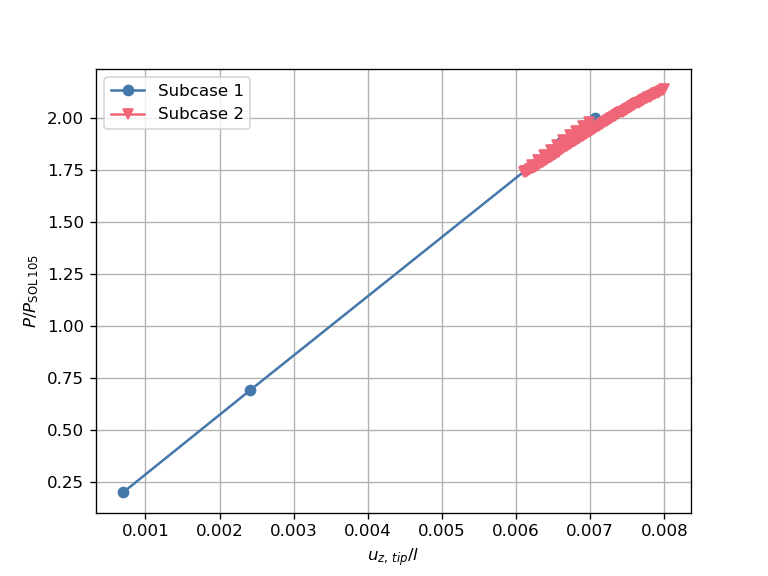

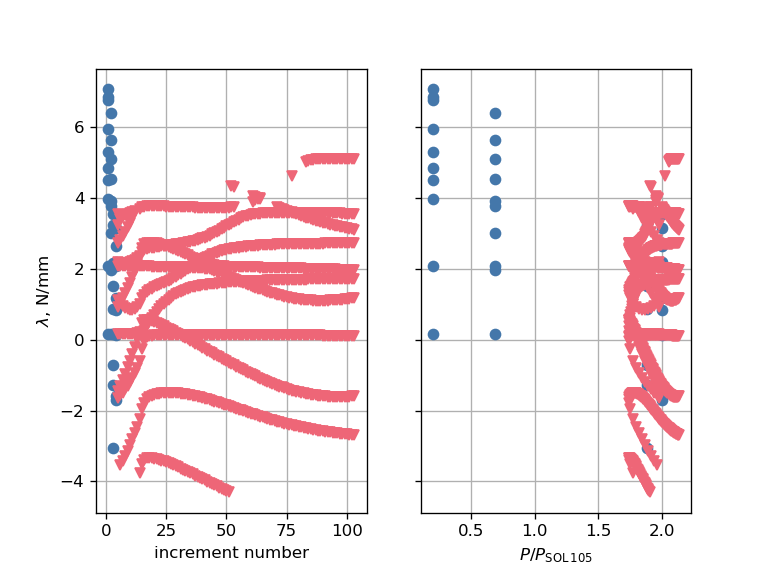

In [9]:
_, applied_loads_pw, displacements = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_pw_op2, node_ids=[tip_master_node_id]
    )
)
tip_displacements_pw = displacements[tip_master_node_id]
plot_load_displacement_diagram(tip_displacements_pw, applied_loads_pw)
plot_tangent_stiffness_matrix_eigenvalues(
    ANALYSIS_DIRECTORY_PATH, input_name, applied_loads_pw
)

From the plots above we can observe that the first subcase lands on an unstable equilibrium point, as the last converged increment features more than one negative eigenvalue. In the second subcase it becomes clear that such equilibrium points belongs to a complementary path, that is to say to an equilibrium path that is disconnected both from the natural path and from the ground state. In fact, in the second subcase the applied loads and displacements reach a minimum around $P/P_\text{SOL 105}=1.75$ and then increase along a different trajectory. Contrary to the complementary path found for the unreinforced box beam in our [last notebook](14_Investigation_of_the_Equilibrium_Paths_of_the_Unreinforced_Box_Beam.ipynb), this complementary path appears to be completely unstable.

In the eigenvalue diagram we can observe that not all eigenvalues of the second subcase start from the final eigenvalues of the first subcase and that some eigenvalues are lost after a certain increment number. This is caused by the fact that we use the Lanczos method to calculate the eigenvalues of $\boldsymbol{K}_T$. In fact, the Lanczos method calculates the first $N$ eigenvalues of a matrix from the smallest in magnitude to the largest. When one eigenvalue disappears after a certain increment number, it means that such eigenvalue is no longer among the 10 smallest magnitude eigenvalues. 

In addition, we can observe a clutter of eigenvalues approximately between the 50th and the 75th converged increment. By looking into the f06 file we can see that for those increments the eigensolver found less than 10 eigenvalues and this explains the reason for the apparent mess in that part of the eigenvalue diagram.

Now let's try to unload the structure with the load control method to verify that we can jump from the complementary path to the natural path. What we expect to observe in this analysis is in fact a jump around $P/P_\text{SOL 105}=1.75$. We modify our `BDF` object by deleting the `NLPCI` card, in order to remove the arc-length control. The we run the analysis and we plot the results.

Nastran job equilibrium_path_verification_pw_load_control.bdf completed
Wall time: 601.0 s


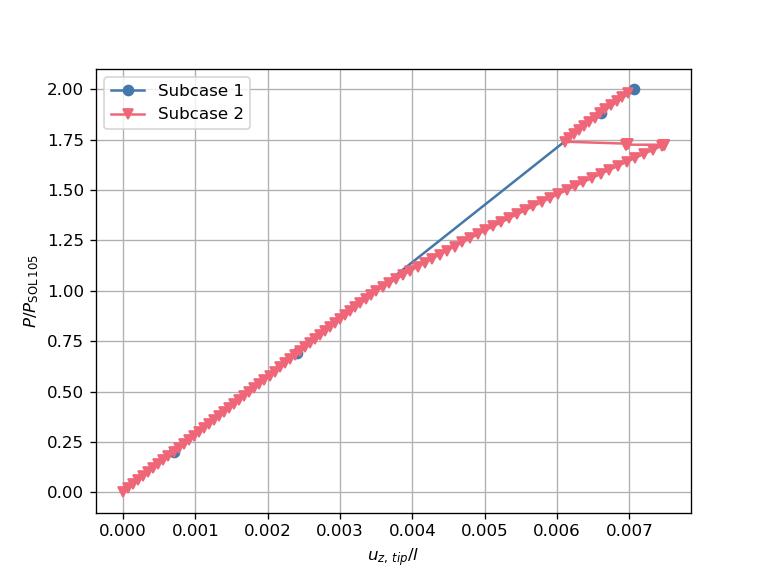

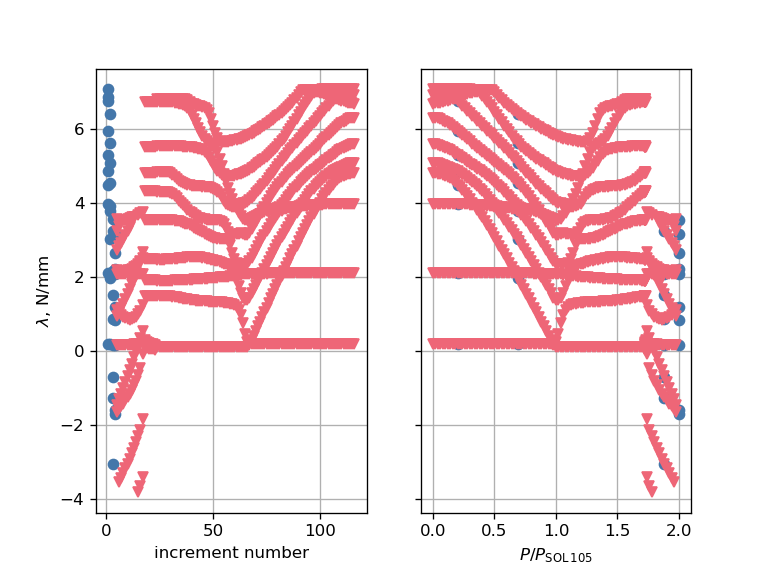

In [10]:
# Remove NLPCI card to activate load control method
del box_beam_bdf.nlpcis[SECOND_SUBCASE_ID]

# Run analysis
input_name = "equilibrium_path_verification_pw_load_control"
sol_106_pw_load_control_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=box_beam_bdf.__deepcopy__({}),
    method_set_id=zero_load_set_id + 1,
    no_eigenvalues=no_eigenvalues,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    run_flag=False,
)

# Plot results
_, applied_loads_pw_load_control, displacements = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_pw_load_control_op2, node_ids=[tip_master_node_id]
    )
)
tip_displacements_pw_load_control = displacements[tip_master_node_id]
plot_load_displacement_diagram(
    tip_displacements_pw_load_control, applied_loads_pw_load_control
)
plot_tangent_stiffness_matrix_eigenvalues(
    ANALYSIS_DIRECTORY_PATH, input_name, applied_loads_pw_load_control
)

We indeed observe a clear jump at $P/P_\text{SOL 105}=1.75$, both in the load-displacement and in the eigenvalue diagram. At the same time, in the load-displacement diagram we can notice a few equilibrium points in the middle of the jump. By zooming into both diagrams, it appears that these equilibrium points belong to another equilibrium path, however stable this time, which is also disconnected from the natural path and from the ground state, given the additional jump observed. It is then possible that the Newton solver jumped first on another complementary path and then on the natural path, finally succeding to completely unload the structure.

In fact, since the FE model of our box beam has many degrees of freedom, it is well possible that a number of complementary path exists in the equilibrium manifold. However, finding all complementary paths of the box beam within the investigated load range is out of the scope of this notebook, so we won't look further into the additional equilibrium path found with the last analysis.

Next, we want to perform a similar analysis using the load and displacement error functions. We then define the two subcases with the following nonlinear analysis parameters, run the analysis and plot the resutls:
1. concentrated tip load, load and displacement error functions, default remaining parameters;
2. no load, load and displacement error functions with vector component method, fine nonlinear analysis parameters:
    - $\Delta\mu^1=0.01$,
    - $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$,
    - $\mathrm{MAXBIS}=10$,
    - $\mathrm{MINALR}=0.01$,
    - $\mathrm{MAXALR}=1.0001$,
    - $\mathrm{DESITER}=5$.
    - $\mathrm{MXINC}=100$.

Nastran job equilibrium_path_verification_pu.bdf completed
Wall time: 247.0 s


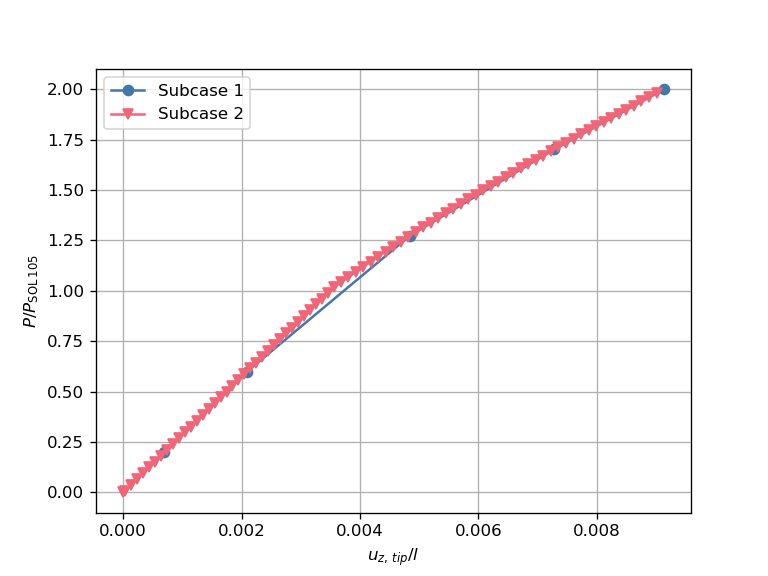

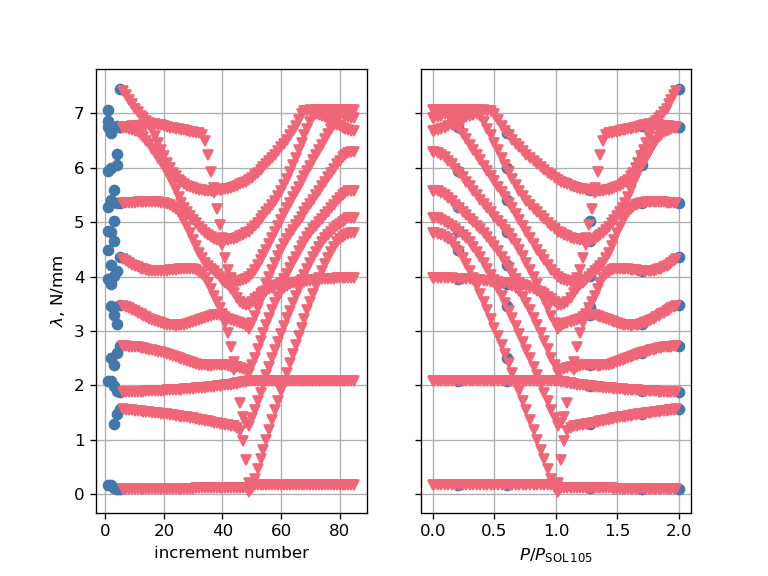

In [11]:
# Modify convergence tolerances of first subcase
box_beam_bdf.nlparms[FIRST_SUBCASE_ID].conv = "PU"

# Reactivate arc-length method for second subcase
box_beam_bdf.add_nlpci(
    nlpci_id=SECOND_SUBCASE_ID,
    Type="CRIS",
    minalr=0.01,
    maxalr=1.0001,
    desiter=5,
    mxinc=100,
)

# Run analysis
input_name = "equilibrium_path_verification_pu"
sol_106_pu_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=box_beam_bdf.__deepcopy__({}),
    method_set_id=zero_load_set_id + 1,
    no_eigenvalues=no_eigenvalues,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    run_flag=False,
)  # run analysis and read OP2 file

# Plot results
_, applied_loads_pu, displacements = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_pu_op2, node_ids=[tip_master_node_id]
    )
)  # find load and displacement history
tip_displacements_pu = displacements[tip_master_node_id]
plot_load_displacement_diagram(
    tip_displacements_pu, applied_loads_pu
)  # plot load-displacement diagram
plot_tangent_stiffness_matrix_eigenvalues(
    ANALYSIS_DIRECTORY_PATH, input_name, applied_loads_pu
)  # plot eigenvalue diagram

In this case it seems evident that the equilibrium points of the first subcase belong to the natural path, and for this reason the structure is succesfully unloaded in the second subcase.

## Visualization of 3D equilibrium diagram and deformation shapes <a name="visualization"></a>

***

Now we want to visualize together the natural and the complementary paths. Similarly to our last notebook, we want to plot a 3D load-displacement diagram with the applied load against the tip displacement and a local displacement. We choose the latter to be the displacement along the $z$-axis of the node where the linear buckling analysis (SOL 105) predicts the largest displacement of the critical buckling mode.

We delete our previous subcases and call the function `run_sol_105` from the `pynastran_utils` module in order to find the id of the node where the maximum displacement occurs according to the linear buckling prediction.

In [12]:
# Delete subcases 1 and 2
for subcase_id in range(1, 3):
    del box_beam_bdf.subcases[subcase_id]

# Run linear buckling analysis
input_name = "linear_buckling_analysis"
sol_105_op2 = pynastran_utils.run_sol_105(
    bdf=box_beam_bdf.__deepcopy__({}),
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    static_load_set_id=FORCE_SET_ID,
    method_set_id=FORCE_SET_ID + 1,
    run_flag=False,
)

# Find node where max displacement occurs
max_displacement_index = np.argmax(
    sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, Z_INDEX]
)  # index where max displacement occurs in data array
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[
    max_displacement_index, 0
]  # id of node where max displacement occurs

Let's visualize the critical buckling mode and the position of the node where the maximum displacement occurs.

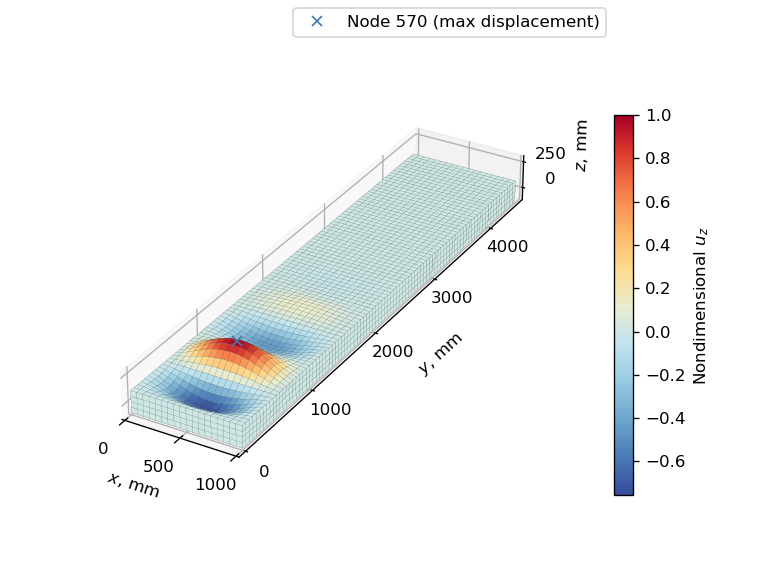

In [13]:
from resources import plot_utils

# Plot critical buckling mode
amplification_factor = 200
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2,
    subcase_id=SECOND_SUBCASE_ID,
    displacement_amplification_factor=amplification_factor,
    displacement_component="tz",
    colormap="sunset",
    length_unit="mm",
)

# Plot node of max displacement
max_displacement_node_xyz = (
    sol_105_op2.nodes[max_displacement_node_id].xyz
    + amplification_factor
    * sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]
)  # we multiply the eigenvector by the default displacement scale factor of plot_eigenvector
ax.plot(
    max_displacement_node_xyz[0],
    max_displacement_node_xyz[1],
    max_displacement_node_xyz[2],
    "x",
    label=f"Node {max_displacement_node_id:d} (max displacement)",
    zorder=4,
)
ax.legend()


# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(
        axis="y", which="major", pad=20
    )  # adjust position of ticks' label of y-axis
    axes.tick_params(
        axis="z", which="major", pad=6
    )  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(
            colorbar.ax.get_position().shrunk(1.0, 0.66)
        )  # decrease colorbar size
        colorbar.ax.set_position(
            colorbar.ax.get_position().translated(-0.05, 0.14)
        )  # move colorbar upwards


# Set axes ticks and labels' position and show plot
adjust_3d_plot(ax, cbar)
plt.show()

The last step before producing our 3D equilibrium diagram consists in finding the displacement history at node 570, $u_{z,\,570}$, for the natural and the complementary equilibrium paths.

In [14]:
# Read local displacement history of along natural equilibrium path
_, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_pu_op2, node_ids=[max_displacement_node_id]
)
local_displacements_natural_path = displacements[max_displacement_node_id]

# Read local displacement history of along complementary equilibrium path
_, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_pw_op2, node_ids=[max_displacement_node_id]
)
local_displacements_complementary_path = displacements[max_displacement_node_id]

We can now produce our 3D equilibrium diagram, nondimensionalizing the tip displacement with the length $l$ of the box beam and the local displacement with the width $w$.

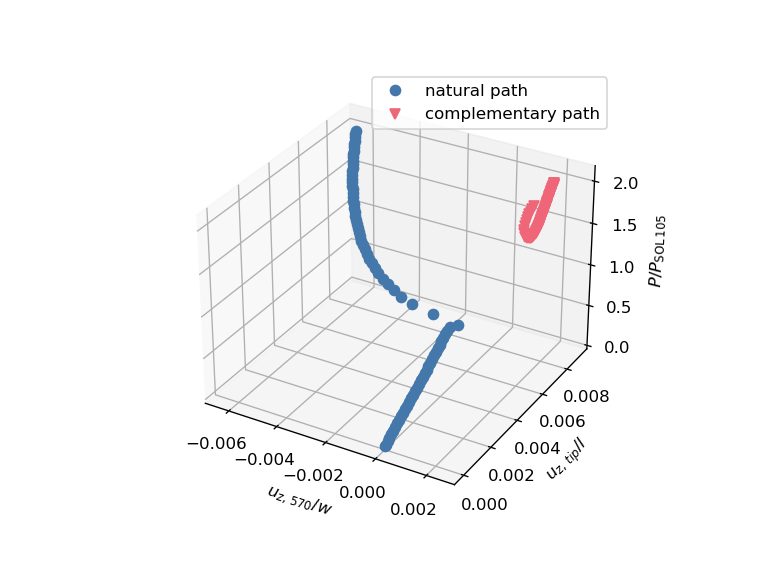

In [15]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection="3d")

# Plot applied load against tip and local displacements
nondimensional_local_displacements = {
    "natural path": local_displacements_natural_path[SECOND_SUBCASE_ID][:, Z_INDEX] / w,
    "complementary path": local_displacements_complementary_path[SECOND_SUBCASE_ID][
        :, Z_INDEX
    ]
    / w,
}
nondimensional_tip_displacements = {
    "natural path": tip_displacements_pu[SECOND_SUBCASE_ID][:, Z_INDEX] / l,
    "complementary path": tip_displacements_pw[SECOND_SUBCASE_ID][:, Z_INDEX] / l,
}
nondimensional_applied_loads = {
    "natural path": applied_loads_pu[SECOND_SUBCASE_ID][:, Z_INDEX]
    / SOL_105_BUCKLING_LOAD,
    "complementary path": applied_loads_pw[SECOND_SUBCASE_ID][:, Z_INDEX]
    / SOL_105_BUCKLING_LOAD,
}
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(
        nondimensional_local_displacements[key],
        nondimensional_tip_displacements[key],
        nondimensional_applied_loads[key],
        MARKERS[count],
        color=COLORS[count],
        label=key,
    )  # plot applied loads against tip and local displacements

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

From the plot above we have a clear visualization of the complementary path being disconnected from the natural path. However, we can also notice something suspicious along the natural path. In fact, following the equilibrium path from the ground state towards an increasing applied load, we can see that when we approach and exceed $P/P_\text{SOL 105}=1$ the local displacement initially seems to increase with a positive value and then it jumps to negative values. What is happening here?

Let's try to load the structure from the ground state to $P/P_\text{SOL 105}=2$ with fine arc-length increments and see what happens.

Nastran job natural_equilibrium_path_verification.bdf completed
Wall time: 331.0 s


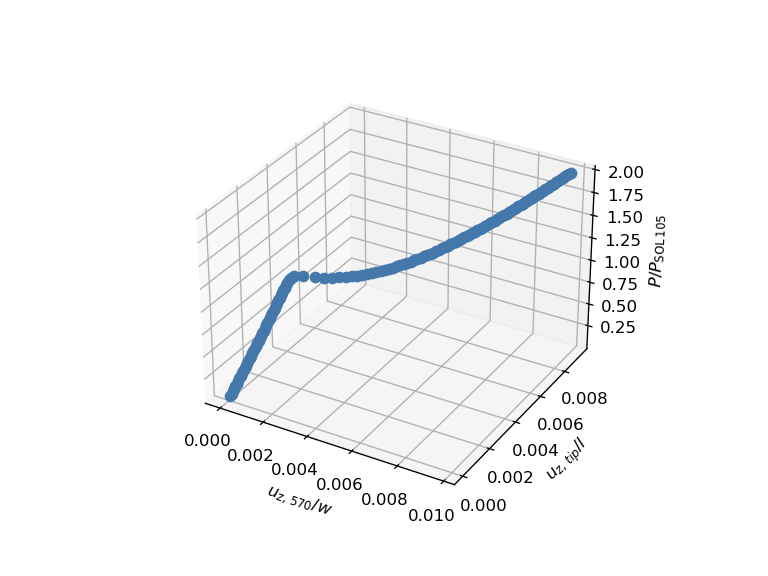

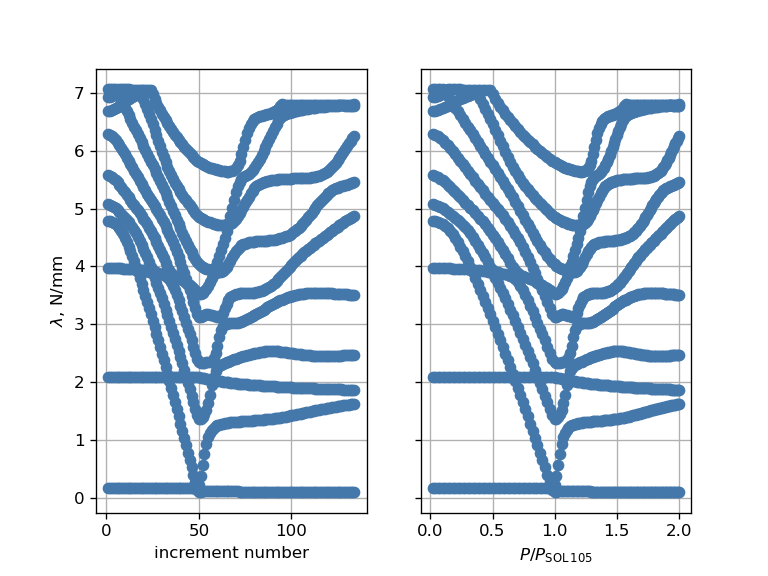

In [16]:
# Create first subcase and select NLPARM and NLPCI card with fine arc-length incremenets
pynastran_utils.create_static_load_subcase(
    bdf=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID
)
box_beam_bdf.case_control_deck.subcases[0].params["NLPARM"][0] = SECOND_SUBCASE_ID
box_beam_bdf.nlpcis[SECOND_SUBCASE_ID].mxinc = (
    140  # increase maximum number of allowed increments to prevent the analysis from stopping before convergence
)

# Run analysis and read applied loads and displacements from OP2 object
input_name = "natural_equilibrium_path_verification"
sol_106_natural_path_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=box_beam_bdf.__deepcopy__({}),
    method_set_id=zero_load_set_id + 1,
    no_eigenvalues=no_eigenvalues,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    run_flag=False,
)
_, applied_loads_natural_path, displacements = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_natural_path_op2,
        node_ids=[max_displacement_node_id, tip_master_node_id],
    )
)
local_displacements_natural_path = displacements[max_displacement_node_id]
tip_displacements_natural_path = displacements[tip_master_node_id]

# Plot 3D equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
ax_3d.plot3D(
    local_displacements_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / w,
    tip_displacements_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / l,
    applied_loads_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / SOL_105_BUCKLING_LOAD,
    MARKERS[0],
    color=COLORS[0],
)  # plot applied loads against tip and local displacements
ax_3d.set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

# Plot eigenvalue diagram
plot_tangent_stiffness_matrix_eigenvalues(
    ANALYSIS_DIRECTORY_PATH, input_name, applied_loads_natural_path
)

The above plot confirms our suspicion. In fact, we can see that when we exceed $P/P_\text{SOL 105}=1$ the local displacement increases monotonically with a positive value. Furthermore, the eigenvalue diagram confirms that the structure is stable along the whole path, as we would expect for the natural path of our box beam. This means that the actual natural equilibrium path is the one that we have just found in the last analysis and not the one that we found in the previous analysis. What is then the other equilibrium path and why does the solver jumping to the actual natural path instead of following it?

If we look back at the results of the 1-DOF system of our [second notebook](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb#1dof), we can see that the simplest example of a complementary path in a broken supercritical pitchfork is made by an equilibrium path made by a stable segment and an unstable segment, which are close to the equilibrium paths of the supercritical pitchfork bifurcation of the perfectly symmetric system. The 3D equilibrium diagram shown earlier suggests that the equilibrium path found in the previous analysis might correspond to the stable segment of a complementary path that is very close to the supercritical pitchfork bifurcation of the system associated to our box beam loaded in a way that does not break any symmetry. If that's the case, why does the arc-length solver jump from the complementary path to the actual natural path and does not follow the complementary path through its unstable segment?

Looking at the f06 file of the previous analysis we notice that the vast majority of arc-length increments converged in 2 or 3 iterations. The number of iterations is greater only when approaching $P/P_\text{SOL 105}=1$ and it achieves a maximum value of 6 and 7 just before and just after such applied load. What is happening here?

The arc-length method is a predictor-corrector method, meaning that it first makes a prediction of the next equilibrium point by taking a tangent step to the load-displacement diagram and then it corrects the prediction to find the actual equilibrium point by means of Newton-Raphson iterations. The prediction is thus based on the tangent stiffness matrix evaluated at the last converged equilibrium point. If the equilibrium path is highly nonlinear around such point, the predictor step may land relatively far from the followed path. In the event that the predictor step lands closer to a different path, the corrector step will make the solver converge to this new path instead of the old path. When this happens it is likely that the corrector step requires more iterations than usual to converge, as it tries to converge to an equilibrium point that is relatively far from the last converged point. This is what may be happening in our case.

For this reason, we repeat both analyses limiting the maximum number of iterations for each increment to 5. This means that the solver will reduce the size of the predictor step where the corrector step cannot converge "easily", that is to say in presence of strong nonlinearities. In this way, we expect the solver to follow the complementary path of the structure without jumping.

In [17]:
# Change NLPARM and NLPCI card of first subcase to use coarse arc-length increments
box_beam_bdf.case_control_deck.subcases[0].params["NLPARM"][0] = FIRST_SUBCASE_ID

# Create second subcase to unload the structure
pynastran_utils.create_static_load_subcase(
    bdf=box_beam_bdf, subcase_id=SECOND_SUBCASE_ID, load_set_id=zero_load_set_id
)
box_beam_bdf.case_control_deck.subcases[subcase_id].add_integer_type(
    "NLPARM", SECOND_SUBCASE_ID
)  # select NLPARM fine arc-length increments for second subcase
box_beam_bdf.nlparms[SECOND_SUBCASE_ID].max_iter = (
    5  # set maximum number of iterations for each increment to 5
)

# Run analysis and read applied loads and displacements from OP2 object
input_name = "equilibrium_path_verification_pu_maxiter5"
sol_106_pu_maxiter5_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=box_beam_bdf.__deepcopy__({}),
    method_set_id=zero_load_set_id + 1,
    no_eigenvalues=no_eigenvalues,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    run_flag=False,
)
_, applied_loads_pu_maxiter5, displacements = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_pu_maxiter5_op2,
        node_ids=[max_displacement_node_id, tip_master_node_id],
    )
)
local_displacements_pu_maxiter5 = displacements[max_displacement_node_id]
tip_displacements_pu_maxiter5 = displacements[tip_master_node_id]

Nastran job equilibrium_path_verification_pu_maxiter5.bdf completed
Wall time: 372.0 s


Now we plot the results in terms of 3D equilibrium diagram and eigenvalue diagram. This time, we also add the natural equilirbium path found earlier to the 3D equilibrium diagram for reference.

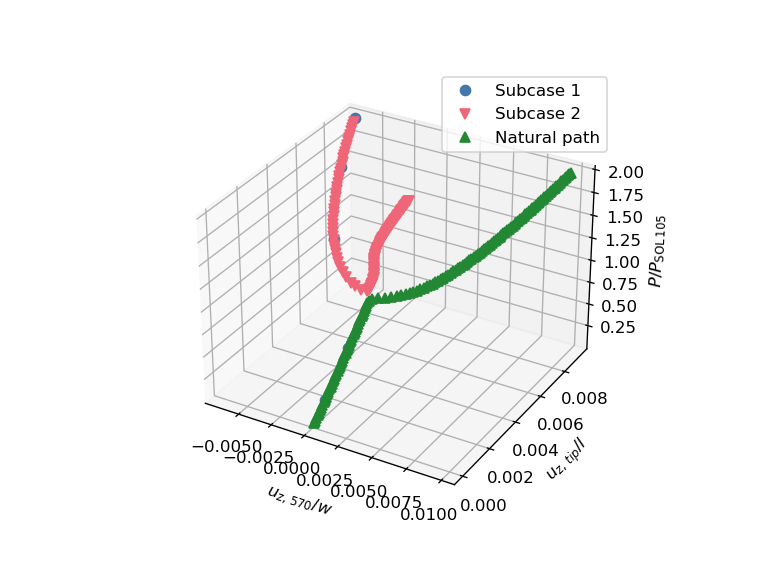

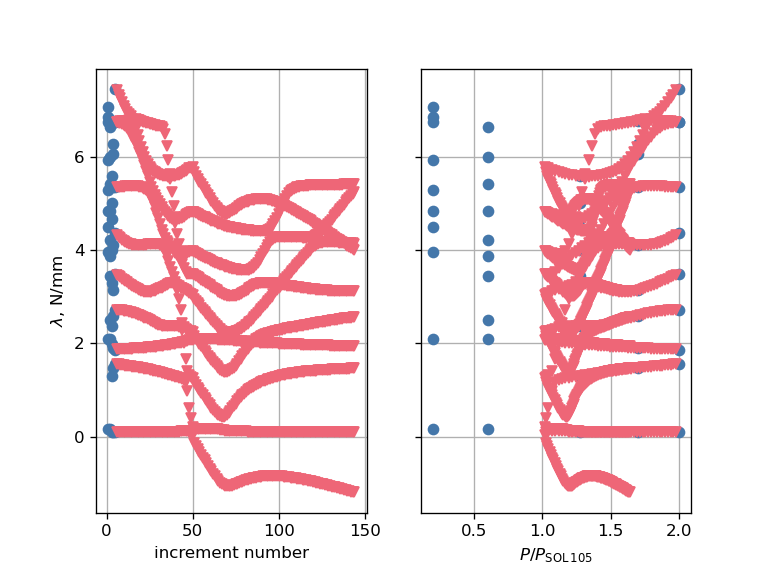

In [18]:
# Plot 3D equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
for count, subcase_id in enumerate(applied_loads_pu_maxiter5.keys()):
    ax_3d.plot3D(
        local_displacements_pu_maxiter5[subcase_id][:, Z_INDEX] / w,
        tip_displacements_pu_maxiter5[subcase_id][:, Z_INDEX] / l,
        applied_loads_pu_maxiter5[subcase_id][:, Z_INDEX] / SOL_105_BUCKLING_LOAD,
        MARKERS[count],
        color=COLORS[count],
        label=f"Subcase {subcase_id:d}",
    )
ax_3d.set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)

# Plot 3D equilibrium diagram of natural path for reference
ax_3d.plot3D(
    local_displacements_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / w,
    tip_displacements_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / l,
    applied_loads_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / SOL_105_BUCKLING_LOAD,
    MARKERS[2],
    color=COLORS[2],
    label="Natural path",
)
ax_3d.legend()
plt.show()

# Plot eigenvalue diagram
plot_tangent_stiffness_matrix_eigenvalues(
    ANALYSIS_DIRECTORY_PATH, input_name, applied_loads_pu_maxiter5
)

The above plot confirms our expectation on the complementary path. In fact, we can see that the arc-length solver follows the equilibrium path without jumping to the natural path and transitions to the unstable segment.

Now let's plot together in the same 3D equilibrium diagram the natural path and the two complementary paths that we have found in this notebook.

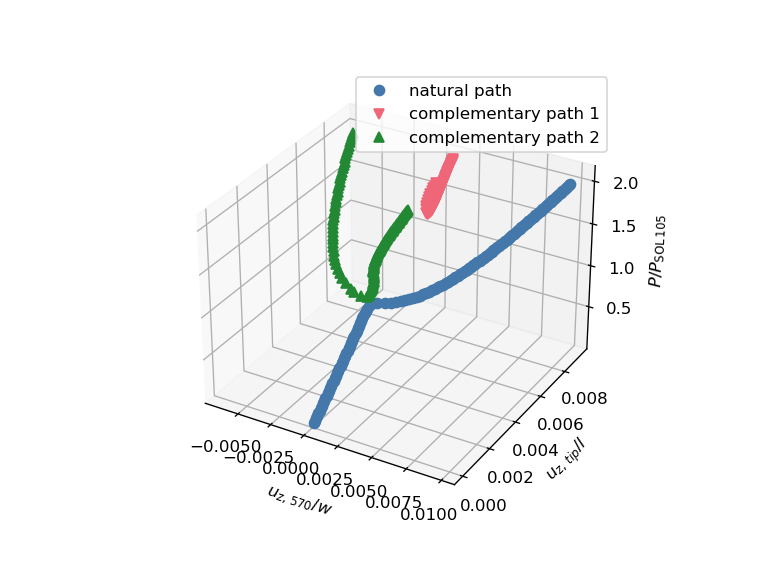

In [19]:
# Define loads and displacements for natural path
nondimensional_local_displacements["natural path"] = (
    local_displacements_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / w
)
nondimensional_tip_displacements["natural path"] = (
    tip_displacements_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / l
)
nondimensional_applied_loads["natural path"] = (
    applied_loads_natural_path[FIRST_SUBCASE_ID][:, Z_INDEX] / SOL_105_BUCKLING_LOAD
)

# Define loads and displacements for first complementary path
nondimensional_local_displacements["complementary path 1"] = (
    nondimensional_local_displacements.pop("complementary path")
)
nondimensional_tip_displacements["complementary path 1"] = (
    nondimensional_tip_displacements.pop("complementary path")
)
nondimensional_applied_loads["complementary path 1"] = nondimensional_applied_loads.pop(
    "complementary path"
)

# Define loads and displacements for second complementary path
nondimensional_local_displacements["complementary path 2"] = (
    local_displacements_pu_maxiter5[SECOND_SUBCASE_ID][:, Z_INDEX] / w
)
nondimensional_tip_displacements["complementary path 2"] = (
    tip_displacements_pu_maxiter5[SECOND_SUBCASE_ID][:, Z_INDEX] / l
)
nondimensional_applied_loads["complementary path 2"] = (
    applied_loads_pu_maxiter5[SECOND_SUBCASE_ID][:, Z_INDEX] / SOL_105_BUCKLING_LOAD
)

# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection="3d")

# Plot applied load against tip and local displacements
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(
        nondimensional_local_displacements[key],
        nondimensional_tip_displacements[key],
        nondimensional_applied_loads[key],
        MARKERS[count],
        color=COLORS[count],
        label=key,
    )  # plot applied loads against tip and local displacements

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

What is the deformation shape on the different equilibrium paths? Let's explore this by cutting the equilibrium paths with a plane at $P/P_\text{SOL 105}=1.9$.

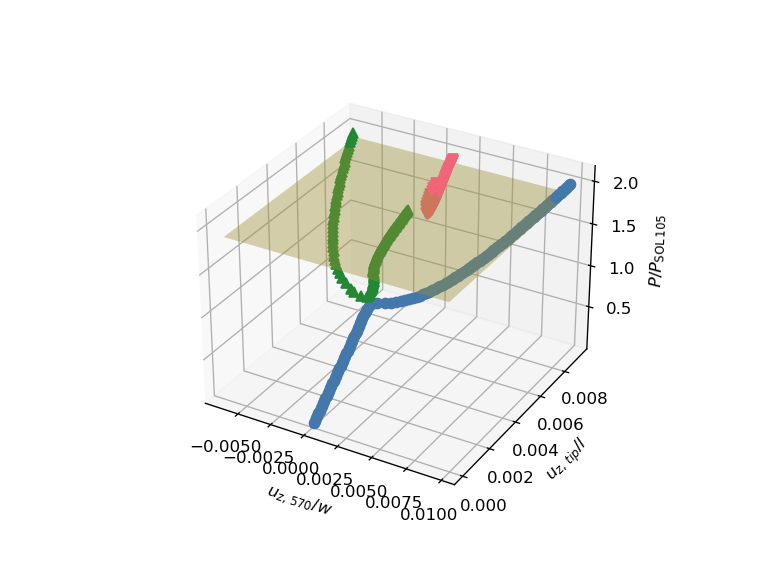

Deformation on natural path:


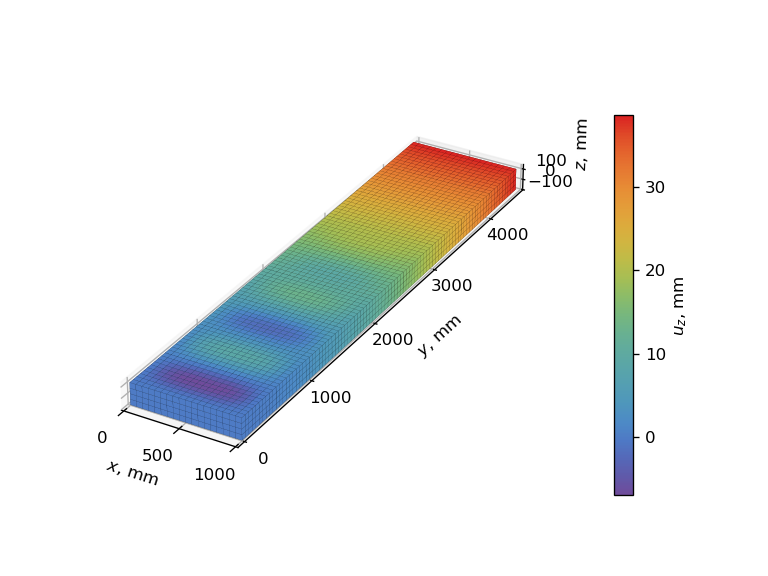

Deformations on first complementary path:


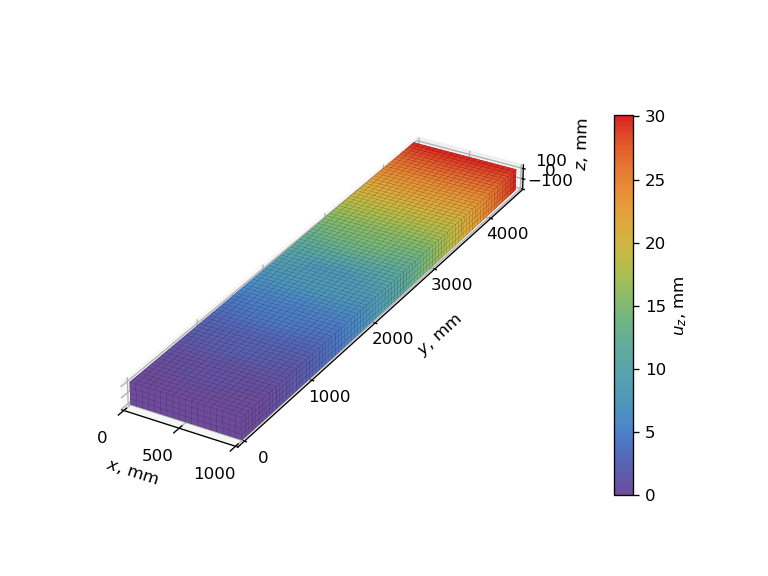

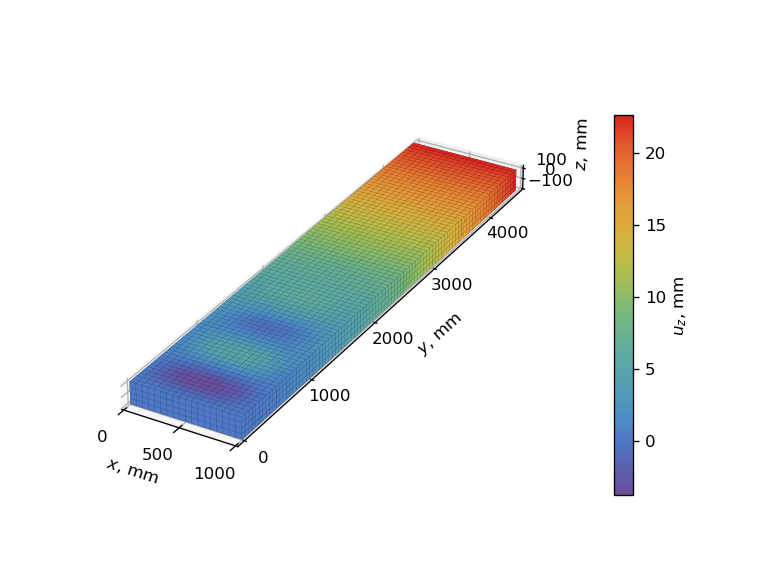

Deformation on second complementary path:


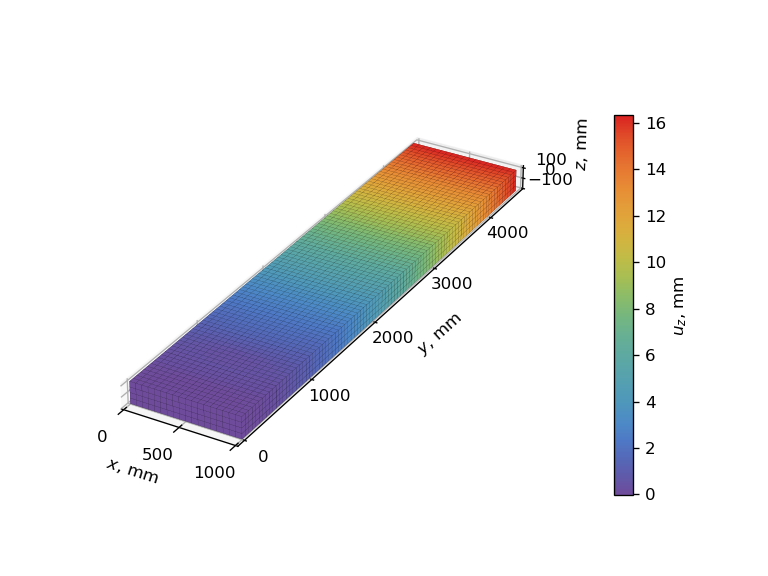

In [20]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection="3d")

# Plot part of the equilibrium paths below the P/Psol105=1.9 plane
load_factor = 1.9
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(
        nondimensional_local_displacements[key],
        nondimensional_tip_displacements[key],
        np.where(
            nondimensional_applied_loads[key] < load_factor,
            nondimensional_applied_loads[key],
            np.nan,
        ),
        MARKERS[count],
        color=COLORS[count],
    )

# Plot P/Psol105=1.9 plane
local_displacements_array = np.concatenate(
    tuple(
        nondimensional_local_displacements[key]
        for key in nondimensional_local_displacements
    )
)
tip_displacements_array = np.concatenate(
    tuple(
        nondimensional_tip_displacements[key]
        for key in nondimensional_tip_displacements
    )
)
xx, yy = np.meshgrid(
    [np.min(local_displacements_array), np.max(local_displacements_array)],
    [np.min(tip_displacements_array), np.max(tip_displacements_array)],
)
ax_3d.plot_surface(
    xx,
    yy,
    np.full_like(xx, load_factor),
    alpha=0.4,
    color=COLORS[len(nondimensional_local_displacements)],
)

# Plot part of the equilibrium paths above the P/Psol105=1.9 plane
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(
        nondimensional_local_displacements[key],
        nondimensional_tip_displacements[key],
        np.where(
            nondimensional_applied_loads[key] >= load_factor,
            nondimensional_applied_loads[key],
            np.nan,
        ),
        MARKERS[count],
        color=COLORS[count],
        zorder=3,
    )

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

# Find closest load step to P/Psol105=1.9 plane on natural equilibrium path
load_step = (
    np.argmin(np.abs(nondimensional_applied_loads["natural path"] - load_factor)) + 1
)

# Plot static deformation of natural path
print("Deformation on natural path:")
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_natural_path_op2,
    subcase_id=FIRST_SUBCASE_ID,
    load_step=load_step,
    displacement_component="tz",
    length_unit="mm",
)
adjust_3d_plot(ax, cbar)
plt.show()

# Find closest load step to P/Psol105=1.9 plane on first side of complementary path 1
min_load_index = np.argmin(nondimensional_applied_loads[key])
load_step = (
    np.argmin(np.abs(nondimensional_applied_loads[key][:min_load_index] - load_factor))
    + 1
)

# Plot first deformation on complementary path 1
print("Deformations on first complementary path:")
key = "complementary path 1"
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_pw_load_control_op2,
    subcase_id=SECOND_SUBCASE_ID,
    load_step=load_step,
    displacement_component="tz",
    length_unit="mm",
)
adjust_3d_plot(ax, cbar)
plt.show()

# Find closest load step to P/Psol105=1.9 plane on second side of complementary path 1
load_step = (
    np.argmin(np.abs(nondimensional_applied_loads[key][min_load_index:] - load_factor))
    + min_load_index
    + 1
)

# Plot second deformation on complementary path 1
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_pw_load_control_op2,
    subcase_id=SECOND_SUBCASE_ID,
    load_step=load_step,
    displacement_component="tz",
    length_unit="mm",
)
adjust_3d_plot(ax, cbar)
plt.show()


# Find closest load step to P/Psol105=1.9 plane on complementary path 2
load_step = np.argmin(np.abs(nondimensional_applied_loads[key] - load_factor)) + 1

# Plot deformation on complementary path 2
print("Deformation on second complementary path:")
key = "complementary path 2"
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_pu_maxiter5_op2,
    subcase_id=SECOND_SUBCASE_ID,
    load_step=load_step,
    displacement_component="tz",
    length_unit="mm",
)
adjust_3d_plot(ax, cbar)
plt.show()

The deformation shape is different for every equilibrium point inspected and the top skin appears always in a buckled-like state, except for the first point of the first complementary path. Furthermore, we can observe that the deformation shapes of the natural path and of the second complementary path are one the "mirror" image of the other, as where the natural path exhibits a positive out-of-plane displacement, the second complementary path exhibits a negative out-of-plane displacement and viceversa. This reinforces our parallelism with the example of the 1-DOF system of our [second notebook](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb#1dof), where the deformation shapes of the natural path and the stable segment of the complementary path are one the "mirror" image of the other.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have verified the existence of complementary equilibrium paths in the equilibrium manifold of the box beam reinforced with ribs. More specifically, we were able to find two different complementary paths, disconnected from the natural path. Similarly to our last notebook, this was possible by choosing very coarse arc-length and by playing around with the error functions of the nonlinear analysis. However, we remind that the same caveats and reflections in terms of the limited visualization of the equilibrium manifold apply here as well.

In addition, we have also found out that the arc-length solver may jump from one equilirbium path to another. This might happen when the predictor step lands in the proximity of a different equilibrium path than the one followed and the corrector step cannot converge to the old path. In this case, the solver will converge to the new path instead of the old path. This is what happened in our case, where the solver jumped from the complementary path to the natural path. We have also seen that this can be avoided by limiting the maximum number of iterations for each increment, allowing the solver to reduce the size of the predictor step where the corrector step cannot converge "easily".

In the [next notebook](16_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb) we are going to perform an analogous investigation on the box beam reinforced with ribs and stiffeners.